# Pipeline de Treinamento do

O objetivo desse pipeline é contruir um modelo de machine learning que realize previsões da IBU das cervejas. Ele foi projetado pensando em reutilização e também uma futura possíbilidade de implementar CI/CD.

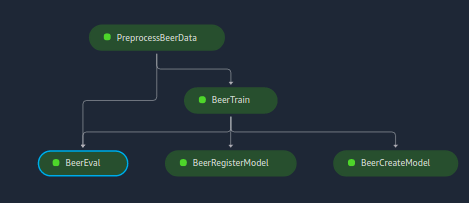

In [ ]:
#!pip install pyathena

In [176]:
import os

import boto3
import sagemaker

from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput

from sagemaker.processing import ProcessingInput, ProcessingOutput, Processor, ScriptProcessor

from sagemaker import Model
from sagemaker.xgboost import XGBoostPredictor
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.model_metrics import (
    MetricsSource,
    ModelMetrics,
)
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
)
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.steps import ProcessingStep, TrainingStep, CacheConfig, TuningStep
from sagemaker.workflow.step_collections import RegisterModel, CreateModelStep
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import (
    ConditionStep,
    JsonGet,
)
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    WarmStartConfig,
    WarmStartTypes,
)

from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.steps import CreateModelStep

from sagemaker.model_metrics import MetricsSource, ModelMetrics
from sagemaker.workflow.step_collections import RegisterModel

from pyathena import connect
import pandas as pd
from io import StringIO 

In [161]:
#os.chdir('..')

In [169]:
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
default_bucket = sagemaker.session.Session().default_bucket()


boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client("sagemaker")
runtime_client = boto_session.client("sagemaker-runtime")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_runtime_client=runtime_client,
    default_bucket=default_bucket,
)

model_package_group_name = f"BeerRegressionIbu"
pipeline_name = f"BeerMLPipeline"
base_job_prefix = "beer"

bucket_cleaned = 'beer-transformed'


# Coleta de dados

Primeiro coletamos uma amostra aleatória do athenas

In [173]:

conn = connect(s3_staging_dir=f's3://{bucket_cleaned}', region_name=region)
df = pd.read_sql(
    f"""
        SELECT *
        FROM "beer-db"."beer-table"
    """, conn)

In [174]:
df.head()

,id,name,ibu,target_fg,target_og,ebc,srm,ph
0,45,The Physics,47.0,1010.0,1048.5,65.0,32.5,4.4
1,7,AB:12,35.0,1017.0,1108.0,80.0,40.0,5.3
2,168,Jack Hammer,250.0,1010.0,1065.0,15.0,7.5,4.4
3,247,Self Assembly Pope,75.0,1016.0,1072.0,200.0,101.6,5.1
4,157,Edge,36.0,1010.0,1033.0,57.0,29.0,4.4


 Depois salva no bucket do dataset.

In [177]:
bucket = 'beer-dataset'
csv_buffer = StringIO()
df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'dataset.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '36BZB440NZC2E7WG',
  'HostId': 'JAGJdVM5oN+80oYTJrXP6ymvt3mM7JgVnxKwyJs7oLYucIX66Uydzuw/WthQDAxeh/navEAdtc4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'JAGJdVM5oN+80oYTJrXP6ymvt3mM7JgVnxKwyJs7oLYucIX66Uydzuw/WthQDAxeh/navEAdtc4=',
   'x-amz-request-id': '36BZB440NZC2E7WG',
   'date': 'Thu, 16 Sep 2021 19:42:47 GMT',
   'etag': '"10a664136c6f0bc0b9fed5c758015d08"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"10a664136c6f0bc0b9fed5c758015d08"'}

# Pipeline de Machine Learning

### Parâmetros para a execução do pipeline
Os parâmetros definidos para o pipeline:

* `processing_instance_type` - O tipo de instância
* `processing_instance_count` - Número de instâncias
* `training_instance_type` - O tipo de instância
* `input_data` - A localização do URI do intervalo S3 dos dados de entrada


In [178]:
processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
processing_instance_type = ParameterString(
    name="ProcessingInstanceType", default_value="ml.m5.xlarge"
)
training_instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.m5.xlarge")
model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)
input_data = ParameterString(
    name="InputDataUrl",
    default_value=f"s3://beer-dataset/dataset.csv",
)

cache_config = CacheConfig(enable_caching=True, expire_after="30d")

## Preprocessamento

Antes de realizar o treinamento do modelo é necessário realizar o preprocessamento dos dados. Todo processo de preparação de dados se encontra no arquivo `preprocessing.py`, onde realizamos as seguintes operações.

- Remover os dados ausentes
- Normalizar todos as features númericas
- Separar dados de acordo com o parâmetro `train-test-split-ratio`

In [179]:
sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    base_job_name=f"{base_job_prefix}/sklearn-beer-preprocess",
    sagemaker_session=sagemaker_session,
    role=role,
)
step_process = ProcessingStep(
    name="PreprocessBeerData",
    processor=sklearn_processor,
    inputs=[ProcessingInput(source=input_data, destination="/opt/ml/processing/input")],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
    ],
    code="src/pipelines/preprocessing.py",
    job_arguments=["--train-test-split-ratio", "0.2"],
    cache_config=cache_config,
)

## Treinamento

Com os dados de treinamento que foram preparados na etapa anterior, utilizamos como entrada para o treinamento do modelo, junto com os hiperparemtros definidos abaixo.

O modelo se encontra no bucket `f"s3://{default_bucket}/BeerTrain"` e arquivo realizado para o treinamento é o `src/pipelines/train.py`

In [180]:
from sagemaker.estimator import Estimator


model_path = f"s3://{default_bucket}/BeerTrain"

estimator = SKLearn(
    entry_point='src/pipelines/train.py',
    framework_version='0.23-1',
    role=role,
    instance_count=1, 
    instance_type=training_instance_type,
    output_path=model_path,
    hyperparameters={
        'max_depth': 2,
        'n_estimators': 100,
        'random_state': None
    }
)

In [192]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


step_train = TrainingStep(
    name="BeerTrain",
    estimator=estimator,
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        )
    },
)

## Avaliação do Modelo

Com o modelo treinado iremos avalia-lo utilizando os dados de teste que foram preparado na etapa de `PreprocessBeerData`. Avaliaremos utilizando o arquivo `evaluete.py` e as métricas utilizadas são MSE e R1.

In [193]:
script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="script-beer-eval",
    role=role,
)

In [194]:
evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)
step_eval = ProcessingStep(
    name="BeerEval",
    processor=script_eval,
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="src/pipelines/evaluate.py",
    property_files=[evaluation_report],
)

## Cração e Registro do modelo

A partir dos artefatos resultantes da etapa de treinamento, iremos criar um modelo Sage Maker e registra-lo.

In [195]:

model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sagemaker_session,
    role=role,
)
inputs = CreateModelInput(
    instance_type="ml.m5.large",
    accelerator_type="ml.eia1.medium",
)
step_create_model = CreateModelStep(
    name="BeerCreateModel",
    model=model,
    inputs=inputs,
)

In [196]:



model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)
step_register = RegisterModel(
    name="BeerRegisterModel",
    estimator=estimator,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)

## Pipeline
Com todos os passos definidos, finalmente podemos criar nosso pipeline, unindo nossos parâmetros citados no inicio do notebook e nossos steps.

In [197]:
pipeline = Pipeline(
    name="beer-pipeline",
    parameters=[
        processing_instance_type,
        processing_instance_count,
        training_instance_type,
        input_data,
        model_approval_status,
    ],
    steps=[step_process, step_train, step_eval, step_register, step_create_model],
    sagemaker_session=sagemaker_session,
)

In [198]:
import json

pipe_definition = json.loads(pipeline.definition())
print(json.dumps(pipe_definition, indent=4, sort_keys=True))

{
    "Metadata": {},
    "Parameters": [
        {
            "DefaultValue": "ml.m5.xlarge",
            "Name": "ProcessingInstanceType",
            "Type": "String"
        },
        {
            "DefaultValue": 1,
            "Name": "ProcessingInstanceCount",
            "Type": "Integer"
        },
        {
            "DefaultValue": "ml.m5.xlarge",
            "Name": "TrainingInstanceType",
            "Type": "String"
        },
        {
            "DefaultValue": "s3://beer-dataset/dataset.csv",
            "Name": "InputDataUrl",
            "Type": "String"
        },
        {
            "DefaultValue": "PendingManualApproval",
            "Name": "ModelApprovalStatus",
            "Type": "String"
        }
    ],
    "PipelineExperimentConfig": {
        "ExperimentName": {
            "Get": "Execution.PipelineName"
        },
        "TrialName": {
            "Get": "Execution.PipelineExecutionId"
        }
    },
    "Steps": [
        {
            "Argume

In [199]:
pipeline.upsert(role_arn=role)
execution = pipeline.start()
execution.wait()

WaiterError: Waiter PipelineExecutionComplete failed: Waiter encountered a terminal failure state: For expression "PipelineExecutionStatus" we matched expected path: "Failed"

# Refeências

- https://github.com/aws/amazon-sagemaker-examples
- https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines.html
- https://sagemaker.readthedocs.io/en/v2.35.0/workflows/pipelines/index.html

